source https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=E0IVW7aybXjy

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# load JLPT vocab and sort into levels 1-4
def load_jlpt():
    jlpt = dict()

    file_names_and_bin_numbers = [
        ('jlpt-voc-4.utf', '4'),
        ('jlpt-voc-3.utf', '3'),
        ('jlpt-voc-2.utf', '2'),
        ('jlpt-voc-1.utf', '1')]

    for file_name, bin_number in file_names_and_bin_numbers:
        with open(file_name, 'r', encoding='utf8') as f:
            for line in f.readlines():
                if line.startswith("#") or line.startswith("\n"):
                    continue

                word_list = line[:-1].split(" ")

                for word in word_list:
                    # checks for invalid words or if the word is already in a lower difficulty bin
                    if word in jlpt:
                      break
                    
                    if '~' in word or word.startswith('（'):
                        continue
                    else:
                      jlpt[word] = bin_number
                      break # don't add kana as separate word

    return jlpt

In [6]:
def add_jlpt_to_freq_list(freq_list, jlpt):
    """
    Adds a JLPT level column to the frequency list dataframe
    1-4 if it has a corresponding JLPT level
    0 if it does not
    """

    jlpt_level = [jlpt[word] if word in jlpt else 0 for word in freq_list.index.values]
    freq_list['jlpt'] = np.array(jlpt_level).astype(int)

    return freq_list

In [7]:
# Load netflix frequency data
freq_df = pd.read_csv('netflix_unidic_3011_no_names_word_freq_report.txt',
                 sep="\t",
                 header=None,
                 index_col=[0], 
                 usecols=[2, 3, 8],
                 names=["word", "kana", "percent"])

In [8]:
# add JLPT level to frequencies
jlpt = load_jlpt()
freq_df = add_jlpt_to_freq_list(freq_df, jlpt)

In [9]:
# load word2vec data
w2v_df = pd.read_csv('./gensim.50d.data.txt', skiprows=1, sep=" ", header=None)
w2v_df = w2v_df.set_index(w2v_df.columns[0])
final_df = pd.merge(freq_df, w2v_df, left_index=True, right_index=True)

In [10]:
# Remove rows with bad data
badbad = ['〆',
          'Ａ','ａ','Ｂ','ｂ','Ｃ','ｃ','Ｄ','ｄ','Ｅ','ｅ','Ｆ','ｆ','Ｇ','ｇ','Ｈ','ｈ','Ｉ','ｉ','Ｊ','ｊ','Ｋ','ｋ','Ｌ','ｌ','Ｎ','ｎ','Ｍ','ｍ','Ｏ','ｏ','Ｐ','ｐ','Ｑ','ｑ','Ｒ','ｒ','Ｓ','ｓ','Ｔ','ｔ','Ｕ','ｕ','Ｖ','ｖ','Ｗ','ｗ','Ｘ','ｘ','Ｙ','ｙ','Ｚ','ｚ',
          'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

for bad in badbad:
  rows = final_df[final_df.index.str.startswith(bad, na=False)]
  final_df = final_df.drop(rows.index)

# delete duplicates
rows = final_df[final_df.index.duplicated(keep='first')]
final_df = final_df.drop(rows.index)

# move percent to the last column
final_df = final_df[[c for c in final_df if c not in ['percent']] + ['percent']]

In [11]:
# Load and add kanji level data
kanji_levels_df = pd.read_csv('./kanji-levels-df.csv')
kanji_levels_df = kanji_levels_df.set_index(kanji_levels_df.columns[0])

final_df['kanji_level'] = -1.0

# Set kanji Level to max kanji level in word
for i, word in enumerate(final_df.index):
  for ch in word:
    if ch in kanji_levels_df.index:
      val = final_df.iloc[i, final_df.columns.get_loc('kanji_level')]
      if val < 0:
        final_df.iloc[i, final_df.columns.get_loc('kanji_level')] = kanji_levels_df.loc[ch].level
      elif kanji_levels_df.loc[ch].level > val:
        final_df.iloc[i, final_df.columns.get_loc('kanji_level')] = kanji_levels_df.loc[ch].level

In [12]:
# Add kana char count

# create set of phonetic characters
kana_set = set()
for kana_word in final_df['kana'].to_list():
  for ch in kana_word:
    kana_set.add(ch)

# add columns to dataframe
for kana in kana_set:
  final_df[kana] = 0.0

# count kana
for i, word in enumerate(final_df.index):
  kana = final_df.iloc[i, final_df.columns.get_loc('kana')]
  for ch in kana:
    final_df.iloc[i, final_df.columns.get_loc(ch)] += 1

In [13]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

final_df[final_df.columns[1:]] = scaler.fit_transform(final_df[final_df.columns[1:]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [14]:
# check dataframe looks good
final_df

,kana,jlpt,1,2,3,4,5,6,7,8,...,メ,ヤ,ゾ,ュ,シ,ユ,ブ,ポ,チ,ド
ぁああ,アア,-0.268869,-0.032711,0.110134,-0.103400,0.019674,0.279984,0.049392,0.048531,-0.169217,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
ぁん,アン,-0.268869,0.053453,-1.401827,0.666036,0.292591,0.511354,0.192013,1.221021,-0.047496,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
あぁ,アア,-0.268869,0.941401,0.056906,1.103228,0.658280,0.168083,-0.691892,-0.532894,-1.513058,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
ああぁ,アア,-0.268869,0.091637,0.166393,-0.106692,0.018466,0.368516,-0.062478,0.195225,-0.138601,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
ああた,アナタ,-0.268869,-0.162935,0.175928,-0.164433,0.001211,0.261146,-0.108045,0.184136,-0.259849,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
龍驤,リュウジョウ,-0.268869,-2.131193,-0.038544,0.859139,1.821290,0.596406,-0.450992,0.247318,1.596726,...,-0.20097,-0.168984,-0.090805,4.000965,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
龍鱗,リュウリン,-0.268869,-0.128498,0.004705,-0.219257,0.255778,0.241064,0.035247,0.355711,0.028853,...,-0.20097,-0.168984,-0.090805,4.000965,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
龍鳳,リュウホウ,-0.268869,-1.331138,-0.111489,0.811345,1.287158,0.316290,0.095391,0.328517,0.688981,...,-0.20097,-0.168984,-0.090805,4.000965,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406
類,タグイ,-0.268869,-0.194151,0.044714,-0.116013,0.037596,0.384842,0.108720,0.120960,-0.151705,...,-0.20097,-0.168984,-0.090805,-0.231928,-0.41622,-0.118586,-0.178125,-0.091082,-0.266023,-0.202406


In [81]:
# == Hyper Params ==
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)

num_epochs = 100 # for training
# num_epochs = 5  # for validation

batch_size = 16
learning_rate = 1e-3
weight_decay = 1e-3
variational_beta = 0
latent_dims = 8

use_gpu = True
num_feats = 134

In [82]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    item = self.df.iloc[idx, 1:]
    word = row.name
    jlpt = row['jlpt']
    return torch.from_numpy(np.array(item, dtype=np.float32)), word, jlpt

In [83]:
from torch.utils.data import DataLoader

word2vec_dataset = CustomDataset(df=final_df)
word2vec_dataloader = DataLoader(word2vec_dataset, batch_size=batch_size, shuffle=True)

In [84]:
# Autoencoder Architechture

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.fc1 = nn.Linear(in_features=num_feats, out_features=32)
    self.fc_mu = nn.Linear(in_features=32, out_features=latent_dims)
    self.fc_logvar = nn.Linear(in_features=32, out_features=latent_dims)
            
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)
    return x_mu, x_logvar

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.fc1 = nn.Linear(in_features=latent_dims, out_features=32)
    self.fc2 = nn.Linear(in_features=32, out_features=num_feats)
            
  def forward(self, x):
    x = self.fc1(x)
    x = torch.sigmoid(self.fc2(x))
    return x
    
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def forward(self, x):
    # x.view(x.size(0), -1)
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon, latent_mu, latent_logvar
    
  def latent_sample(self, mu, logvar):
    if self.training:
      # the reparameterization trick
      std = logvar.mul(0.5).exp_()
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu
  
  
def vae_loss(recon_x, x, mu, logvar):
  recon_loss = F.mse_loss(recon_x.view(-1, num_feats), x.view(-1, num_feats), reduction='sum')
  kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 9558


In [85]:
optimizer = torch.optim.AdamW(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for word_batch, keys, jlpt_levels in word2vec_dataloader:
        
        word_batch = word_batch.to(device)

        # vae reconstruction
        word_batch_recon, latent_mu, latent_logvar = vae(word_batch)
        
        # reconstruction error
        loss = vae_loss(word_batch_recon, word_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    print('Epoch [%d / %d] reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    train_loss_avg[-1] /= num_batches
    print('                average reconstruction error: %f' % (train_loss_avg[-1]))

Training ...
Epoch [1 / 100] reconstruction error: 9951042.662231
                average reconstruction error: 2013.565897
Epoch [2 / 100] reconstruction error: 9504548.058655
                average reconstruction error: 1923.218952
Epoch [3 / 100] reconstruction error: 9437103.885132
                average reconstruction error: 1909.571810
Epoch [4 / 100] reconstruction error: 9392519.741638
                average reconstruction error: 1900.550332
Epoch [5 / 100] reconstruction error: 9354752.731995
                average reconstruction error: 1892.908282
Epoch [6 / 100] reconstruction error: 9328500.523743
                average reconstruction error: 1887.596221
Epoch [7 / 100] reconstruction error: 9311376.961426
                average reconstruction error: 1884.131316
Epoch [8 / 100] reconstruction error: 9300854.061646
                average reconstruction error: 1882.002036
Epoch [9 / 100] reconstruction error: 9292273.707153
                average reconstruction error: 

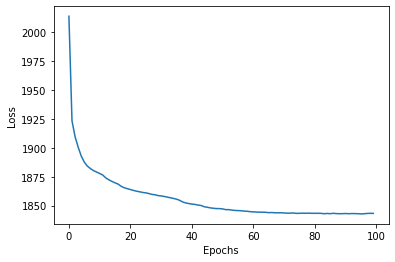

In [86]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

source: https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/06_Autoencoders.ipynb#scrollTo=N2ddujlKlxHi

In [22]:
def get_latent_representation(model,dataloader):

    representation = []
    labels = []

    for word_batch, keys, jlpt_levels in dataloader:
      
        # I guess just do batch size 1 and store all latents?
        word_batch = word_batch.to(device)

        # vae reconstruction
        word_batch_recon, latent_mu, latent_logvar = vae(word_batch)

        representation.append(latent_mu.cpu().detach().numpy())
        labels.append(jlpt_levels.detach().numpy())
    
    # print(representation[0])
    return np.array(representation), np.array(labels)

In [23]:
def latent_rep_PCA_2d(r):
    X = r
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)

    # print(("Explained Variance: %s") % (fit.explained_variance_ratio_))
    return X

In [24]:
def latent_rep_tsne_2d(r):
    X = r
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    X = tsne.fit_transform(X)

    # print(("Explained Variance: %s") % (fit.explained_variance_ratio_))
    return X

In [25]:
def cluster_plot_data(representation,random_state=42):
    from sklearn.cluster import KMeans

    n_clusters=4
    c_pred = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(representation)

    _, ax = plt.subplots(1,1)
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])

    for c in range(n_clusters):
        ind = c_pred == c

        ax.scatter(representation[ind, 0], representation[ind, 1], label=str(c))
    ax.legend()
    plt.title('Clustered features in the representation space')
    plt.show()

    return c_pred

In [89]:
plot_dataloader = DataLoader(word2vec_dataset, batch_size=1, shuffle=True)

r, labels = get_latent_representation(vae,plot_dataloader)

r = r.reshape(r.shape[0], -1)
print(r.shape)

labels = labels.flatten()
print(labels.shape)


df = pd.DataFrame(data=r)
labeldf = pd.DataFrame(data=labels, columns=['label'])

df = pd.concat([df, labeldf], axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('2d_latent_representation.csv',index_col=0)

scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

r = df[df.columns[:-1]].to_numpy()
labeldf = df[df.columns[-1]]

In [12]:
r

array([[-0.03267563,  0.14364305],
       [ 0.2172082 ,  0.35639231],
       [ 0.12206308,  0.29799438],
       ...,
       [ 0.36386055,  0.37998531],
       [ 0.20136643,  0.38604756],
       [ 0.16183455,  0.46576907]])

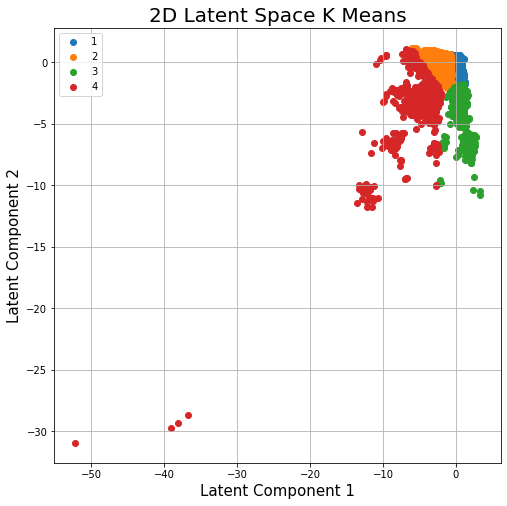

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# make plot with 2-dim latent representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Latent Component 1', fontsize = 15)
ax.set_ylabel('Latent Component 2', fontsize = 15)
ax.set_title('2D Latent Space K Means', fontsize = 20)

targets = np.unique(labeldf.values)[1:]
nice_targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'y']

# for target, color in zip(targets,colors):
#   indicesToKeep = df['label'] == target
#   ax.scatter(df.loc[indicesToKeep, '0'], df.loc[indicesToKeep, '1'], c=color, s=50)



n_clusters=4
c_pred = KMeans(n_clusters=n_clusters, random_state=123).fit_predict(r)

# _, ax = plt.subplots(1,1)
# cm = plt.get_cmap('gist_rainbow')
# ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])

for c in range(n_clusters):
  ind = c_pred == c

  ax.scatter(r[ind, 0], r[ind, 1], label=str(c))

ax.legend(nice_targets)
ax.grid()

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters=4
c_pred = KMeans(n_clusters=n_clusters, random_state=123).fit_predict(df.to_numpy())
silhouette_score(df.to_numpy(), c_pred)

0.2678733838589083

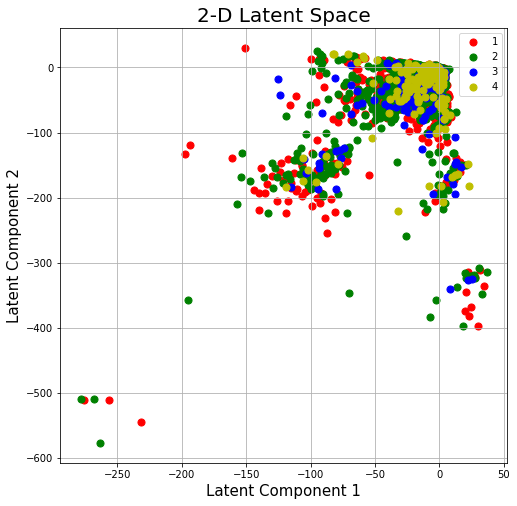

In [51]:
# make plot with 2-dim latent representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Latent Component 1', fontsize = 15)
ax.set_ylabel('Latent Component 2', fontsize = 15)
ax.set_title('2-D Latent Space', fontsize = 20)

targets = np.unique(labeldf.values)[1:]
nice_targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
  indicesToKeep = rdf['label'] == target
  ax.scatter(rdf.loc[indicesToKeep, 'c1'], rdf.loc[indicesToKeep, 'c2'], c=color, s=50)

ax.legend(nice_targets)
ax.grid()

In [31]:
def make_plot(df, labels, type="PCA"):
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Component 1', fontsize = 15)
  ax.set_ylabel('Component 2', fontsize = 15)
  ax.set_title('2 component '+type, fontsize = 20)

  targets = np.unique(labels.values)[1:]
  nice_targets = [1,2,3,4]
  colors = ['r', 'g', 'b', 'y']

  for target, color in zip(targets,colors):
    indicesToKeep = df['label'] == target
    ax.scatter(df.loc[indicesToKeep, 'c1'], df.loc[indicesToKeep, 'c2'], c=color, s=50)
  
  ax.legend(nice_targets)
  ax.grid()

In [110]:
df = pd.read_csv('2d_latent_representation.csv',index_col=0)

scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

r = df[df.columns[:-1]].to_numpy()
labeldf = df[df.columns[-1]]

In [112]:
df

,0,1,label
0,-0.032676,0.143643,-0.268869
1,0.217208,0.356392,-0.268869
2,0.122063,0.297994,-0.268869
3,0.368455,0.382513,-0.268869
4,-0.291278,0.544155,-0.268869
...,...,...,...
79058,0.178862,0.348585,-0.268869
79059,-1.601284,-0.163909,-0.268869
79060,0.363861,0.379985,-0.268869
79061,0.201366,0.386048,-0.268869


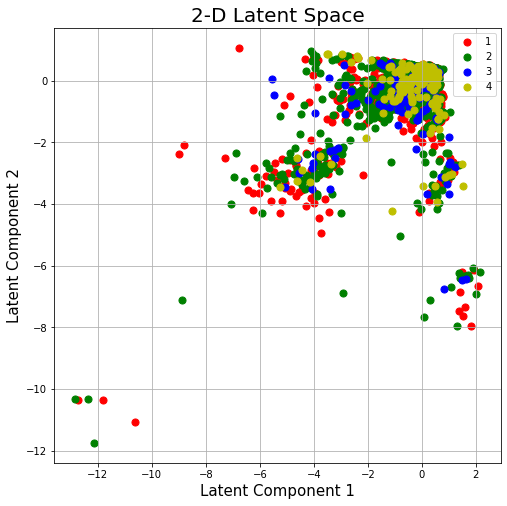

In [114]:
# make plot with 2-dim latent representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Latent Component 1', fontsize = 15)
ax.set_ylabel('Latent Component 2', fontsize = 15)
ax.set_title('2-D Latent Space', fontsize = 20)

targets = np.unique(labeldf.values)[1:]
nice_targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
  indicesToKeep = df['label'] == target
  ax.scatter(df.loc[indicesToKeep, '0'], df.loc[indicesToKeep, '1'], c=color, s=50)

ax.legend(nice_targets)
ax.grid()

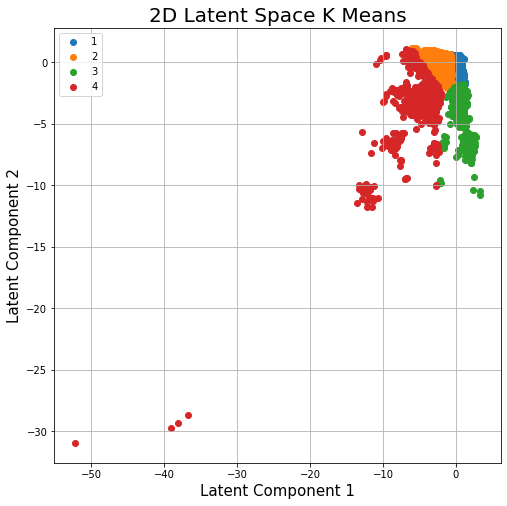

In [118]:
from sklearn.cluster import KMeans

# make plot with 2-dim latent representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Latent Component 1', fontsize = 15)
ax.set_ylabel('Latent Component 2', fontsize = 15)
ax.set_title('2D Latent Space K Means', fontsize = 20)

targets = np.unique(labeldf.values)[1:]
nice_targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'y']

# for target, color in zip(targets,colors):
#   indicesToKeep = df['label'] == target
#   ax.scatter(df.loc[indicesToKeep, '0'], df.loc[indicesToKeep, '1'], c=color, s=50)



n_clusters=4
c_pred = KMeans(n_clusters=n_clusters, random_state=123).fit_predict(r)

# _, ax = plt.subplots(1,1)
# cm = plt.get_cmap('gist_rainbow')
# ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])

for c in range(n_clusters):
  ind = c_pred == c

  ax.scatter(r[ind, 0], r[ind, 1], label=str(c))

ax.legend(nice_targets)
ax.grid()

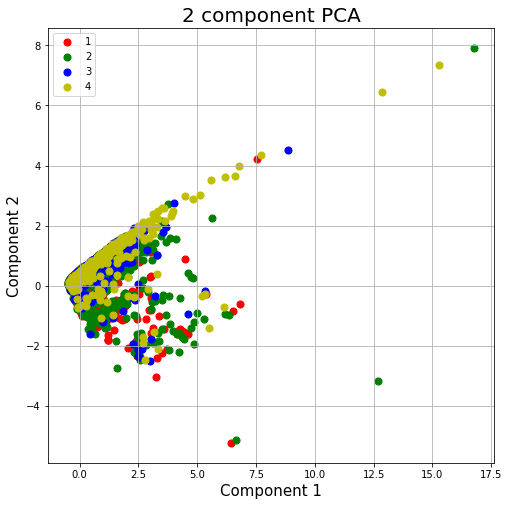

In [108]:
r2dpca = latent_rep_PCA_2d(r)
r2dpcadf = pd.DataFrame(data=r2dpca, columns=['c1', 'c2'])

joinpca = pd.concat([r2dpcadf, labeldf], axis=1)

make_plot(joinpca, labeldf, 'PCA')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 79063 samples in 0.065s...
[t-SNE] Computed neighbors for 79063 samples in 2.860s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79063
[t-SNE] Computed conditional probabilities for sample 2000 / 79063
[t-SNE] Computed conditional probabilities for sample 3000 / 79063
[t-SNE] Computed conditional probabilities for sample 4000 / 79063
[t-SNE] Computed conditional probabilities for sample 5000 / 79063
[t-SNE] Computed conditional probabilities for sample 6000 / 79063
[t-SNE] Computed conditional probabilities for sample 7000 / 79063
[t-SNE] Computed conditional probabilities for sample 8000 / 79063
[t-SNE] Computed conditional probabilities for sample 9000 / 79063
[t-SNE] Computed conditional probabilities for sample 10000 / 79063
[t-SNE] Computed conditional probabilities for sample 11000 / 79063
[t-SNE] Computed conditional probabilities for sample 12000 / 79063
[t-SNE] Computed conditional probabilities for sam

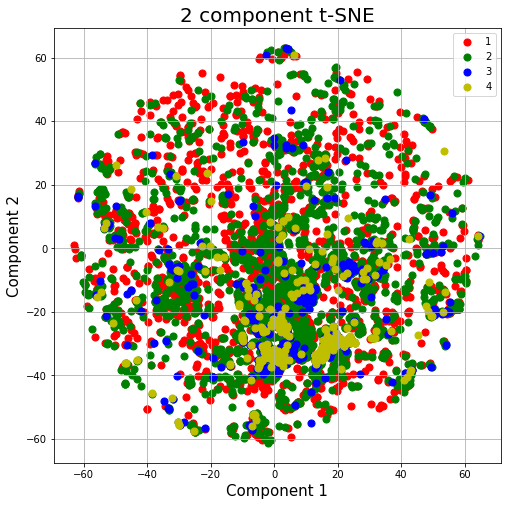

In [109]:
r2dtsne = latent_rep_tsne_2d(r)
r2dtsnedf = pd.DataFrame(data=r2dtsne, columns=['c1', 'c2'])

jointsne = pd.concat([r2dtsnedf, labeldf], axis=1)

make_plot(jointsne, labeldf, 't-SNE')

In [56]:
r1df = pd.DataFrame(data=r)
r2df = pd.DataFrame(data=r)
rdf4d = pd.concat([r1df, r2df], axis=1)
rdf4d.to_numpy()

array([[ -9.5622835, -13.449481 ,  -9.5622835, -13.449481 ],
       [ -4.3257556,  -3.3715734,  -4.3257556,  -3.3715734],
       [ -6.3196025,  -6.1378765,  -6.3196025,  -6.1378765],
       ...,
       [ -1.2525312,  -2.2539759,  -1.2525312,  -2.2539759],
       [ -4.6577334,  -1.966808 ,  -4.6577334,  -1.966808 ],
       [ -5.4861574,   1.8095907,  -5.4861574,   1.8095907]],
      dtype=float32)

0.67848986

In [ ]:
kmeans_counts = []
for i in range(4):
  indices_c_pred = c_pred == i
  classes = labels[indices_c_pred]
  counts = np.bincount(classes)
  kmeans_counts.append(counts)
  print(counts[1:])

[375 683 172 195]
[931 977 131  47]
[1003 1081  133  124]
[247 281  28  41]


In [ ]:
correct = 0
for i in range(4):
  indices_c_pred = c_pred == (i-1)
  classes = labels[indices_c_pred]
  counts = np.bincount(classes)
  class_max = np.argmax(counts)
  correct += (classes == class_max).sum()
  
print('Accuracy of {:.3f}'.format(correct/(1.0*labels.shape[0])))

ValueError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

NameError: ignored

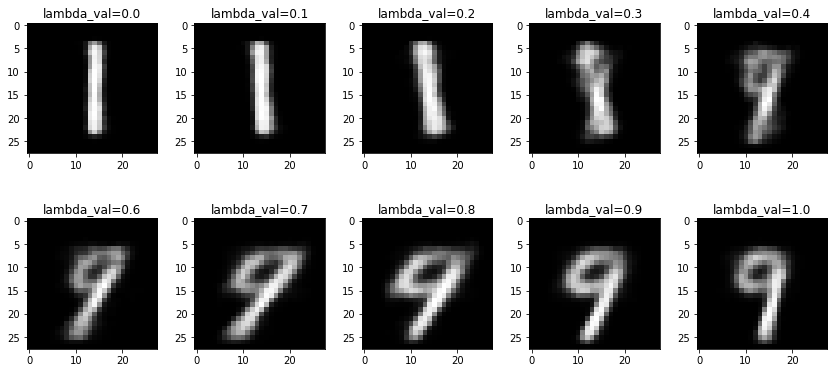

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 